# Sentiment Analysis with NLP for Hotel Accommodation Reviews

- Bowen Lee
- 2017/11/09

## Introduction

Recently I got hotel accommodation reviews data to practice **Sentiment Analysis with Natural Language Processing (NLP)**, which I previously just knew the basics and would like to gain hands-on experience for this **Natural Language Understanding** task. This notebook is to summarize my results.

## Sentiment Analysis with NLP

We will perform Sentiment Analysis with NLP by applying the **Occam's Razor Principle.**

- Collect datasets
- Exploratory data analysis (EDA) with datasets
  * Check missing / abnormal data
  * Group-by aggregate score distributions
- Pre-process datasets
  * Remove missing / abnormal data
  * Join score & review datasets
  * Concat review_title and review_comment to review_title_comments
  * Lower review_title_comments
  * Tokenize and remove stopwords and punctuations
  * Get bag of words
- Sentiment analysis
  * Randomly permutate data
  * Label review
  * Splite training and test sets
  * Machine learning for classification by Naive Bayes Classifier
  * Model evaluation by precision and recall
- Measure real-world performance
  * Predict label based on bag of words
  * Compare two labels's score distributions

### Python scripts

First import Python libraries.

In [1]:
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import nltk
# When performing experiment, remove comment out for nltk.download().
# nltk.download()

import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

The following are the scripts for Sentiment Analysis with NLP.

In [5]:
def read_score_review(score_file, review_file):
    """Read score and review data."""
    score_df = pd.read_csv(score_file)
    review_df = pd.read_csv(review_file)
    return score_df, review_df

In [6]:
def groupby_agg_data(df, gkey='gkey', rid='rid'):
    """Group-by aggregate data."""
    agg_df = (df.groupby(gkey)[rid]
                .count()
                .reset_index())
    nan_count = df[gkey].isnull().sum()
    nan_df = pd.DataFrame({gkey: [np.nan], rid: [nan_count]})
    agg_df = agg_df.append(nan_df)[[gkey, rid]]
    agg_df['percent'] = agg_df[rid] / agg_df[rid].sum()
    return agg_df

In [7]:
def count_missing_data(df, cols='cols'):
    """Count missing records w.r.t. columns."""
    print('Missing rows:')
    for col in cols:
        nan_rows = df[col].isnull().sum()
        print('For {0}: {1}'.format(col, nan_rows))

In [8]:
def slice_abnormal_id(df, rid='hotel_review_id'):
    """View abnormal records with column"""
    abnorm_bool_arr = (df[rid] == 0)
    abnorm_count = abnorm_bool_arr.sum()
    print('abnorm_count: {}'.format(abnorm_count))
    abnorm_df = df[abnorm_bool_arr]
    return abnorm_df

In [9]:
def remove_missing_abnormal_data(score_raw_df, review_raw_df, 
                                 rid='hotel_review_id', 
                                 score_col='rating_overall'):
    """Remove missing / abnormal data."""
    filter_score_bool_arr = (score_raw_df[rid].notnull() & 
                             score_raw_df[score_col].notnull())
    score_df = score_raw_df[filter_score_bool_arr]
    
    filter_review_bool_arr = review_raw_df[rid].notnull()
    review_df = review_raw_df[filter_review_bool_arr]
    
    return score_df, review_df

In [10]:
def join_score_review(score_df, review_df, on='hotel_review_id', how='left'):
    """Join score and review datasets."""
    score_review_df = pd.merge(score_df, review_df, on=on, how=how)
    score_review_count = score_review_df.shape[0]
    print('score_review_count: {}'.format(score_review_count))
    return score_review_df

In [11]:
def concat_review_title_comments(score_review_df, 
                                 concat_cols=['review_title', 'review_comments'],
                                 concat_2col='review_title_comments'):
    """Concat review title and review comments."""
    concat_text_col = ''
    for concat_col in concat_cols:
        concat_text_col += score_review_df[concat_col]
        if concat_col != concat_cols[len(concat_cols) - 1]:
            concat_text_col += '. '
    score_review_df[concat_2col] = concat_text_col
    return score_review_df

In [12]:
def lower_review_title_comments(score_review_df, 
                                lower_col='review_title_comments'):
    """Lower sentences."""
    score_review_df[lower_col] = score_review_df[lower_col].str.lower()
    return score_review_df

In [13]:
def _tokenize_sen(sen):
    """Tokenize one sentence."""
    from nltk.tokenize import word_tokenize
    sen_token = word_tokenize(str(sen))
    return sen_token

In [14]:
def _remove_nonstop_words_puncs(sen):
    """Remove nonstop words and meaningless punctuations in one sentence."""
    from nltk.corpus import stopwords
    sen_clean = [
        word for word in sen 
        if word not in stopwords.words('english') and 
           word not in [',', '.', '(', ')', '&']]
    return sen_clean

In [15]:
def tokenize_clean_sentence(sen):
    """Tokenize and clean one sentence."""
    sen_token = _tokenize_sen(sen)
    sen_token_clean = _remove_nonstop_words_puncs(sen_token)
    return sen_token_clean

In [16]:
# def preprocess_sentence(df, sen_cols=['review_title', 'review_comments']):  
#     """Preprocess sentences (deprecated due to slow performance)."""
#     for sen_col in sen_cols:
#         print('Start tokenizing "{}"'.format(sen_col))
#         sen_token_col = '{}_token'.format(sen_col)
#         df[sen_token_col] = df[sen_col].apply(tokenize_clean_sentence)
#         print('Finish tokenizing "{}"'.format(sen_col))
#     return df

def preprocess_sentence_par(df, sen_col='review_title_comments',
                            sen_token_col='review_title_comments_token', num_proc=32):
    """Preporecess sentences in parallel.
    
    Note: We apply multiprocessing with 32 cores; adjust `num_proc` by your computing environment.
    """
    import multiprocessing as mp
    pool = mp.Pool(num_proc)
    df[sen_token_col] = pool.map_async(tokenize_clean_sentence , df[sen_col]).get()
    return df

In [17]:
def get_bag_of_words(w_ls):
    """Get bag of words in word list."""
    w_bow = dict([(w, True) for w in w_ls])
    return w_bow

In [18]:
def get_bag_of_words_par(df, sen_token_col='review_title_comments_token',
                         bow_col='review_title_comments_bow', num_proc=32):
    """Get bag of words in parallel for sentences."""
    import multiprocessing as mp
    pool = mp.Pool(num_proc)
    df[bow_col] = pool.map_async(get_bag_of_words , df[sen_token_col]).get()
    return df

In [19]:
def label_review(df, scores_ls=None, label='negative',
                 score_col='rating_overall',
                 review_col='review_title_comments_bow'):
    """Label review by positive or negative."""
    df_label = df[df[score_col].isin(scores_ls)]
    label_review_ls = (df_label[review_col]
                       .apply(lambda bow: (bow, label))
                       .tolist())
    return label_review_ls

In [20]:
def permutate(data_ls):
    """Randomly permutate data."""
    np.random.shuffle(data_ls)

In [21]:
def create_train_test_sets(pos_review_ls, neg_review_ls, train_percent=0.75):
    """Create the training and test sets."""
    neg_num = np.int(np.ceil(len(neg_review_ls) * train_percent))
    pos_num = np.int(np.ceil(len(pos_review_ls) * train_percent))
    
    train_set = neg_review_ls[:neg_num] + pos_review_ls[:pos_num]
    permutate(train_set)
    
    test_set =  neg_review_ls[neg_num:] + pos_review_ls[pos_num:]
    permutate(test_set)
    
    return train_set, test_set

In [22]:
def train_naive_bayes(train_set):
    from nltk.classify import NaiveBayesClassifier
    nb_clf = NaiveBayesClassifier.train(train_set)
    return nb_clf

In [23]:
def eval_naive_bayes(test_set, nb_clf):
    import collections
    from nltk.metrics.scores import precision
    from nltk.metrics.scores import recall

    ref_sets = {'positive': set(), 
                'negative': set()}
    pred_sets = {'positive': set(), 
                 'negative': set()}
    
    for i, (bow, label) in enumerate(test_set):
        ref_sets[label].add(i)
        pred_label = nb_clf.classify(bow)
        pred_sets[pred_label].add(i)
        
    print('Positive precision:', precision(ref_sets['positive'], pred_sets['positive']))
    print('Positive recall:', recall(ref_sets['positive'], pred_sets['positive']))
    print('Negative precision:', precision(ref_sets['negative'], pred_sets['negative']))
    print('Negative recall:', recall(ref_sets['negative'], pred_sets['negative']))

In [24]:
def pred_labels(df, clf, 
                bow_col='review_title_comments_bow',
                pred_col='pred_label',
                sel_cols=['rating_overall', 
                          'review_title_comments_bow', 
                          'pred_label']):
    """Predict labels for bag of words."""
    df[pred_col] = df[bow_col].apply(clf.classify)
    df_pred = df[sel_cols]
    return df_pred

In [25]:
def get_boxplot_data(pred_label_df, 
                     pred_col='pred_label', score_col='rating_overall'):
    pos_data = pred_label_df[pred_label_df[pred_col] == 'positive'][score_col].values
    neg_data = pred_label_df[pred_label_df[pred_col] == 'negative'][score_col].values
    box_data = [pos_data, neg_data]
    return box_data

In [26]:
def plot_box(d_ls, title='Box Plot', xlab='xlab', ylab='ylab', 
             xticks=None, xlim=None, ylim=None, figsize=(15, 10)):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib
    matplotlib.style.use('ggplot')
    %matplotlib inline
    plt.figure()
    fig, ax = plt.subplots(figsize=figsize)
    plt.boxplot(d_ls)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if xticks:
        ax.set_xticklabels(xticks)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    # plt.axis('auto')    
    plt.show()

## Collect Data

We first read score and review raw datasets.

- Score dataset: two columns
  * `hotel_review_id`: hotel review sequence ID
  * `rating_overall`: overal accommodation rating
- Review dataset: three columns
  * `hotel_review_id`: hotel review sequence ID
  * `review_title`: review title
  * `review_comments`: detailed review comments

In [50]:
# score_file = 'reviews_score.csv'
# review_file = 'reviews.csv'
score_file = '../datasets/hotel_review/reviews_score.csv'
review_file = '../datasets/hotel_review/reviews.csv'

In [51]:
score_raw_df, review_raw_df = read_score_review(score_file, review_file)

print(len(score_raw_df))
print(len(review_raw_df))

274339
274339


In [ ]:
score_raw_df.head(5)

,hotel_review_id,rating_overall
0,103237986,6
1,103237985,7
2,103237979,7
3,103237975,6
4,103237974,6


In [ ]:
review_raw_df.head(5)

,hotel_review_id,review_title,review_comments
0,103237986,Friendly staff and comfortable stay,Continental breakfast is 7/10
1,103237985,Budget hotel,Hotel is OK but the breakfast taste is so so.
2,103237979,Don't set high expectations,"The hotel has a beautiful lobby, delicately de..."
3,103237975,Good location,Good location and good view. But check-out tim...
4,103237974,Need Renovations,The rooms and facilities are old and needs tot...


## EDA with Datasets 

### Check missing / abnormal data

In [ ]:
count_missing_data(score_raw_df, 
                   cols=['hotel_review_id', 'rating_overall'])

Missing rows:
For hotel_review_id: 0
For rating_overall: 27


In [ ]:
score_raw_df[score_raw_df.rating_overall.isnull()]

,hotel_review_id,rating_overall
5609,0.000000e+00,NaN
6579,0.000000e+00,NaN
19275,0.000000e+00,NaN
24029,0.000000e+00,NaN
27452,0.000000e+00,NaN
41981,0.000000e+00,NaN
54271,0.000000e+00,NaN
69635,0.000000e+00,NaN
70574,0.000000e+00,NaN
73794,0.000000e+00,NaN


In [ ]:
count_missing_data(review_raw_df, 
                   cols=['hotel_review_id', 'review_title', 'review_comments'])

Missing rows:
For hotel_review_id: 0
For review_title: 1151
For review_comments: 220


In [ ]:
abnorm_df = slice_abnormal_id(score_raw_df, rid='hotel_review_id')

abnorm_df

abnorm_count: 24


,hotel_review_id,rating_overall
5609,0,NaN
6579,0,NaN
19275,0,NaN
24029,0,NaN
27452,0,NaN
41981,0,NaN
54271,0,NaN
69635,0,NaN
70574,0,NaN
73794,0,NaN


In [ ]:
abnorm_df = slice_abnormal_id(review_raw_df, rid='hotel_review_id')

abnorm_df

abnorm_count: 24


,hotel_review_id,review_title,review_comments
5609,0,NaN,NaN
6579,0,NaN,NaN
19275,0,NaN,NaN
24029,0,NaN,NaN
27452,0,NaN,NaN
41981,0,NaN,NaN
54271,0,NaN,NaN
69635,0,NaN,NaN
70574,0,NaN,NaN
73794,0,NaN,NaN


### Group-by aggregate score distributions

From the following results we can observe that 

- the `rating_overall` scores are **imbalanced.** Specifically, only about $1\%$ records have low scores $\le 5$, thus about $99\%$ records have scores $\ge 6$.
- some records have **missing score**.

In [ ]:
score_raw_df.rating_overall.unique()

array([  6.,   7.,   9.,   8.,   5.,  10.,   3.,   4.,   2.,  nan])

In [ ]:
score_agg_df = groupby_agg_data(
    score_raw_df, gkey='rating_overall', rid='hotel_review_id')

score_agg_df

,rating_overall,hotel_review_id,percent
0,2,4256,0.015514
1,3,4176,0.015222
2,4,9795,0.035704
3,5,9893,0.036061
4,6,27975,0.101972
5,7,28883,0.105282
6,8,73155,0.266659
7,9,49117,0.179038
8,10,67062,0.244449
0,NaN,27,0.000098


## Pre-process Datasets 

### Remove missing / abnormal data

Since there are few records (only 27) having missing `hotel_review_id` and `rating_overall` score, we just ignore them.

In [ ]:
score_df, review_df = remove_missing_abnormal_data(
    score_raw_df, review_raw_df, 
    rid='hotel_review_id', 
    score_col='rating_overall')

In [ ]:
score_df.head(5)

,hotel_review_id,rating_overall
0,103237986,6
1,103237985,7
2,103237979,7
3,103237975,6
4,103237974,6


In [ ]:
review_df.head(5)

,hotel_review_id,review_title,review_comments
0,103237986,Friendly staff and comfortable stay,Continental breakfast is 7/10
1,103237985,Budget hotel,Hotel is OK but the breakfast taste is so so.
2,103237979,Don't set high expectations,"The hotel has a beautiful lobby, delicately de..."
3,103237975,Good location,Good location and good view. But check-out tim...
4,103237974,Need Renovations,The rooms and facilities are old and needs tot...


### Join score & review datasets

To leverage fast vectorized operation with Pandas DataFrame, we joint score and review datasets.

In [ ]:
score_review_df_ = join_score_review(score_df, review_df)

score_review_df_.head(5)

score_review_count: 274312


,hotel_review_id,rating_overall,review_title,review_comments
0,103237986,6,Friendly staff and comfortable stay,Continental breakfast is 7/10
1,103237985,7,Budget hotel,Hotel is OK but the breakfast taste is so so.
2,103237979,7,Don't set high expectations,"The hotel has a beautiful lobby, delicately de..."
3,103237975,6,Good location,Good location and good view. But check-out tim...
4,103237974,6,Need Renovations,The rooms and facilities are old and needs tot...


The following are the procedure for processing natural language texts.

### Concat review_title and review_comments

Using the Occam's Razor Principle, since `review_title` and `review_comments` both are natural languages, we can simply concat them into one sentence for further natural language processing.

In [ ]:
score_review_df = concat_review_title_comments(
    score_review_df_, 
    concat_cols=['review_title', 'review_comments'],
    concat_2col='review_title_comments')

In [ ]:
score_review_df.head(5)

,hotel_review_id,rating_overall,review_title,review_comments,review_title_comments
0,103237986,6,Friendly staff and comfortable stay,Continental breakfast is 7/10,Friendly staff and comfortable stay. Continent...
1,103237985,7,Budget hotel,Hotel is OK but the breakfast taste is so so.,Budget hotel. Hotel is OK but the breakfast ta...
2,103237979,7,Don't set high expectations,"The hotel has a beautiful lobby, delicately de...",Don't set high expectations. The hotel has a b...
3,103237975,6,Good location,Good location and good view. But check-out tim...,Good location. Good location and good view. Bu...
4,103237974,6,Need Renovations,The rooms and facilities are old and needs tot...,Need Renovations. The rooms and facilities are...


### Lower review_title_comments

In [ ]:
score_review_df = lower_review_title_comments(
    score_review_df, 
    lower_col='review_title_comments')

In [ ]:
score_review_df.head(5)

,hotel_review_id,rating_overall,review_title,review_comments,review_title_comments
0,103237986,6,Friendly staff and comfortable stay,Continental breakfast is 7/10,friendly staff and comfortable stay. continent...
1,103237985,7,Budget hotel,Hotel is OK but the breakfast taste is so so.,budget hotel. hotel is ok but the breakfast ta...
2,103237979,7,Don't set high expectations,"The hotel has a beautiful lobby, delicately de...",don't set high expectations. the hotel has a b...
3,103237975,6,Good location,Good location and good view. But check-out tim...,good location. good location and good view. bu...
4,103237974,6,Need Renovations,The rooms and facilities are old and needs tot...,need renovations. the rooms and facilities are...


### Tokenize and remove stopwords

**Tokenizing** is an important technique by which we would like to split the sentence into vector of invidual words. Nevertheless, there are many **stopwords** that are useless in natural language text, for example: he, is, at, which, and on. Thus we would like to remove them from the vector of tokenized words.

Note that since the tokenizing and removing stopwords tasks are time-consuming, we apply Python build-in package `multiprocessing` for parallel computing to improve the performance.

In [ ]:
start_token_time = time.time()

score_review_token_df = preprocess_sentence_par(
    score_review_df, 
    sen_col='review_title_comments',
    sen_token_col='review_title_comments_token', num_proc=32)

end_token_time = time.time()
print('Time for tokenizing: {}'.format(end_token_time - start_token_time))

Time for tokenizing: 121.193218946


In [ ]:
score_review_token_df.head(5)

,hotel_review_id,rating_overall,review_title,review_comments,review_title_comments,review_title_comments_token
0,103237986,6,Friendly staff and comfortable stay,Continental breakfast is 7/10,friendly staff and comfortable stay. continent...,"[friendly, staff, comfortable, stay, continent..."
1,103237985,7,Budget hotel,Hotel is OK but the breakfast taste is so so.,budget hotel. hotel is ok but the breakfast ta...,"[budget, hotel, hotel, ok, breakfast, taste]"
2,103237979,7,Don't set high expectations,"The hotel has a beautiful lobby, delicately de...",don't set high expectations. the hotel has a b...,"[n't, set, high, expectations, hotel, beautifu..."
3,103237975,6,Good location,Good location and good view. But check-out tim...,good location. good location and good view. bu...,"[good, location, good, location, good, view, c..."
4,103237974,6,Need Renovations,The rooms and facilities are old and needs tot...,need renovations. the rooms and facilities are...,"[need, renovations, rooms, facilities, old, ne..."


In [ ]:
score_review_token_df.review_title_comments_token[1]

['budget', 'hotel', 'hotel', 'ok', 'breakfast', 'taste']

### Get bag of words

The tokenized words may contain duplicated words, and for simplicity, we would like to apply the **Bag of Words,** which just represents the sentence as a bag (multiset) of its words, ignoring grammar and even word order. Here, following the Occam's Razor Principle again, we do not keep word frequencies, thus we use binary (presence/absence or True/False) weights.

In [ ]:
start_bow_time = time.time()

score_review_bow_df = get_bag_of_words_par(
    score_review_token_df, 
    sen_token_col='review_title_comments_token',
    bow_col='review_title_comments_bow', num_proc=32)

end_bow_time= time.time()
print('Time for bag of words: {}'.format(end_bow_time - start_bow_time))

Time for bag of words: 8.3695089817


In [ ]:
score_review_bow_df.review_title_comments_bow[:5]

0    {u'stay': True, u'continental': True, u'7/10':...
1    {u'taste': True, u'breakfast': True, u'hotel':...
2    {u'taxi': True, u'walking': True, u'cheap': Tr...
3    {u'check-out': True, u'good': True, u'soon': T...
4    {u'needs': True, u'old': True, u'renovations':...
Name: review_title_comments_bow, dtype: object

## Sentiment Analysis

### Label data

Since we would like to **polarize data** with consideration for the **imbalanced data problem** as mentioned before, we decide to label

- ratings 2, 3 and 4 by "negative",
- ratings 9 and 10 by "positive".

In [ ]:
neg_review_ls = label_review(
    score_review_bow_df,
    scores_ls=[2, 3, 4], label='negative',
    score_col='rating_overall',
    review_col='review_title_comments_bow')

In [ ]:
pos_review_ls = label_review(
    score_review_bow_df,
    scores_ls=[9, 10], label='positive',
    score_col='rating_overall',
    review_col='review_title_comments_bow')

In [ ]:
neg_review_ls[1]

({'annoying': True,
  'booked': True,
  'disappointing': True,
  'discomfort': True,
  'enjoy': True,
  'fear': True,
  'filled': True,
  'lodge': True,
  "n't": True,
  'owner': True,
  'place': True,
  'quite': True,
  'receptionist': True,
  'rude': True,
  'statements': True,
  'stay': True,
  'told': True,
  'unfriendly': True},
 'negative')

In [ ]:
pos_review_ls[1]

({'hot': True, 'overall-good': True, 'sauna': True, 'tub': True, 'work': True},
 'positive')

### Splite training and test sets

We split the training and test sets by the rule of $75\%$ and $25\%$.

In [ ]:
train_set, test_set = create_train_test_sets(
    pos_review_ls, neg_review_ls, train_percent=0.75)

In [ ]:
train_set[10]

({'!': True,
  'come': True,
  'go': True,
  'hotel': True,
  'ipoh': True,
  'love': True,
  'nothing': True,
  'say..perfect': True},
 'positive')

### Naive Bayes Classification

We first apply **Naive Bayes Classifier** to learn positive or negative sentiment. 

In [ ]:
nb_clf = train_naive_bayes(train_set)

### Model evaluation

We evaluate our model by **positive / negative precision and recall.** From the results we can observe that our model performs fairly good.

In [ ]:
eval_naive_bayes(test_set, nb_clf)

Positive precision: 0.976486961617
Positive recall: 0.917986503236
Negative precision: 0.62166454892
Negative recall: 0.859086918349


## Measure Real-World Performance

### Predict label based on bag of words

In [ ]:
start_pred_time = time.time()

pred_label_df = pred_labels(
    score_review_bow_df, nb_clf, 
    bow_col='review_title_comments_bow',
    pred_col='pred_label')

end_pred_time = time.time()
print('Time for prediction: {}'.format(end_pred_time - start_pred_time))

Time for prediction: 42.6269350052


In [ ]:
pred_label_df.head(5)

,rating_overall,review_title_comments_bow,pred_label
0,6,"{u'stay': True, u'continental': True, u'7/10':...",positive
1,7,"{u'taste': True, u'breakfast': True, u'hotel':...",positive
2,7,"{u'taxi': True, u'walking': True, u'cheap': Tr...",positive
3,6,"{u'check-out': True, u'good': True, u'soon': T...",positive
4,6,"{u'needs': True, u'old': True, u'renovations':...",negative


### Compare two labels's score distributions

From the following boxplot, we can observe that our model performs reasonably well in the real world, even by our suprisingly simple machine learning modeling. 

We can further apply divergence measures, such as Kullback-Leibler divergence, to quantify the rating_overall distribution distance between two label groups, if needed. 

In [ ]:
box_data = get_boxplot_data(
    pred_label_df, 
    pred_col='pred_label', score_col='rating_overall')

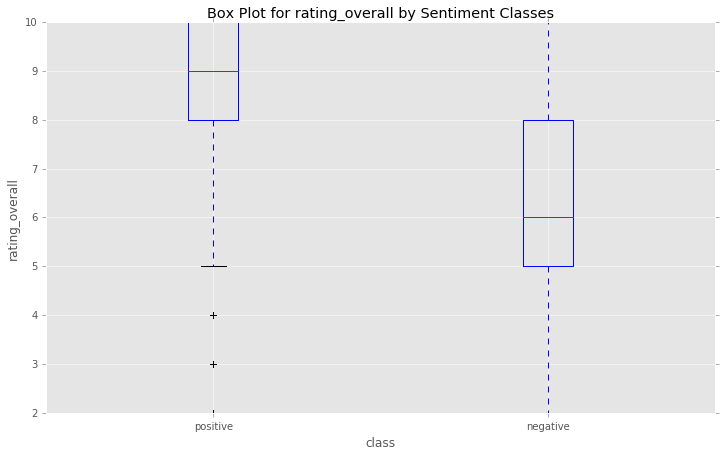

In [ ]:
plot_box(box_data, title='Box Plot for rating_overall by Sentiment Classes', 
         xlab='class', ylab='rating_overall', 
         xticks=['positive', 'negative'], figsize=(12, 7))

## Discussions

- Following Occam's Razor Principle, we first apply the "standard" approach for Sentiment Analysis with Natural Language Processing.
- Our simple Naive Bayes Classifier performs fairly well in model evaluation and real-world performance, by investigating precision and recall for positive and negative sentiment and by viewing boxplot, respectively.
- Note that our model predicts really good at positive reviews which generally produce high `rating_overall`. Nevertheless, the model performs comparably bad at negative reviews since some would produce above average rating_overall. The reason for this is because the `rating_overall` distribution is *imbalanced* and leads to much less negative reviews.
- Thus, to improve the model performance, we can resolve the imbalanced data problem by applying Sampling Techniques, for example positive sampling by which we keep all negative records and sample positive ones for better classification. (We will say sampling techniques for the imbalanced data problem later.)
- We can further enhance the performance by applying more advanced machine learning models with L1/L2-regularizations, or by using better Feature Engineering techniques, such as Bigrams or by learning word embeddings with Word2Vec.
- Furthermore, we can apply Divergence Measures, such as Kullback-Leibler divergence, to quantify the rating_overall distribution distance between two label groups. By calculating divergence measures we can quantify our enhancements.